In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import emd
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

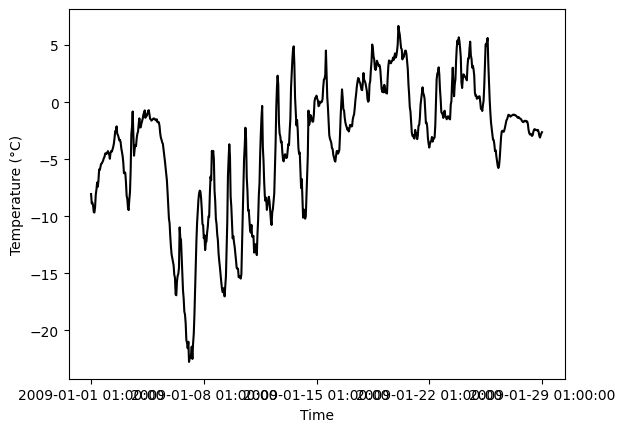

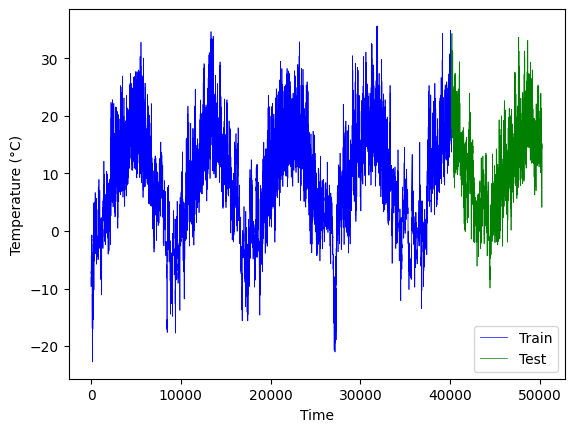

In [2]:
# Cargar datos
df = pd.read_csv('./../data/weather_dataset_preprocesado.csv')
target_column = 'T (degC)'
target_index = 'datetime'
load = df[target_column]
time = df[target_index]
x_label = 'Time'
y_label = 'Temperature (°C)'

# Visualizar datos
plt.plot(time[:673], load[:673], color='k', label='Real')
plt.xticks(np.arange(0, 673, step=168))
plt.xlabel(xlabel=x_label)
plt.ylabel(ylabel=y_label)
plt.show()

# Dividir datos en entrenamiento y prueba
train = load[:int(len(load) * 0.8)]
test = load[int(len(load) * 0.8):]
plt.plot(train, label='Train', color='b', linewidth=0.5)
plt.plot(test, label='Test', color='g', linewidth=0.5)
plt.xlabel(xlabel=x_label)
plt.ylabel(ylabel=y_label)
plt.legend()
plt.show()

# Crear DataFrames para los conjuntos de entrenamiento y prueba
df_train = pd.DataFrame(train)
df_test = pd.DataFrame(test)

# Generar características de retraso
for i in range(1, 4):
    df_train["lag{}".format(i)] = df_train[target_column].shift(i)
    df_test["lag{}".format(i)] = df_test[target_column].shift(i)

df_train = df_train.bfill().drop(columns=[target_column])
df_test = df_test.bfill().drop(columns=[target_column])

,imf_eemd_1,imf_eemd_2,imf_eemd_3,imf_eemd_4,imf_eemd_5,imf_eemd_6,imf_eemd_7,imf_eemd_8,imf_eemd_9,imf_eemd_10
0,1.230337,-2.572774,1.334845,-0.496211,-2.441478,0.588470,-0.755512,-3.126744,-11.292156,1.855360
1,1.690125,-1.722682,1.191259,-0.446027,-2.424243,0.672090,-0.763945,-3.122514,-11.289864,1.855802
2,2.606030,-0.473501,1.377657,-0.356224,-2.395559,0.756592,-0.772292,-3.118241,-11.287566,1.856243
3,-3.799374,0.346095,1.851618,-0.242598,-2.356043,0.841910,-0.780550,-3.113925,-11.285261,1.856685
4,0.744071,0.943761,2.338599,-0.119111,-2.306309,0.927967,-0.788721,-3.109567,-11.282949,1.857127
...,...,...,...,...,...,...,...,...,...,...
40174,-1.401881,-1.464846,-4.007259,4.129528,1.842029,-2.154991,1.264144,2.773492,9.818533,5.715292
40175,-1.115927,-0.439195,-4.354851,4.250542,1.863965,-2.152680,1.263034,2.772513,9.817770,5.715023
40176,4.587241,1.172340,-4.357224,4.317269,1.879505,-2.149805,1.261898,2.771516,9.817004,5.714755
40177,5.813851,2.178411,-4.144499,4.327125,1.888514,-2.146365,1.260734,2.770502,9.816236,5.714485


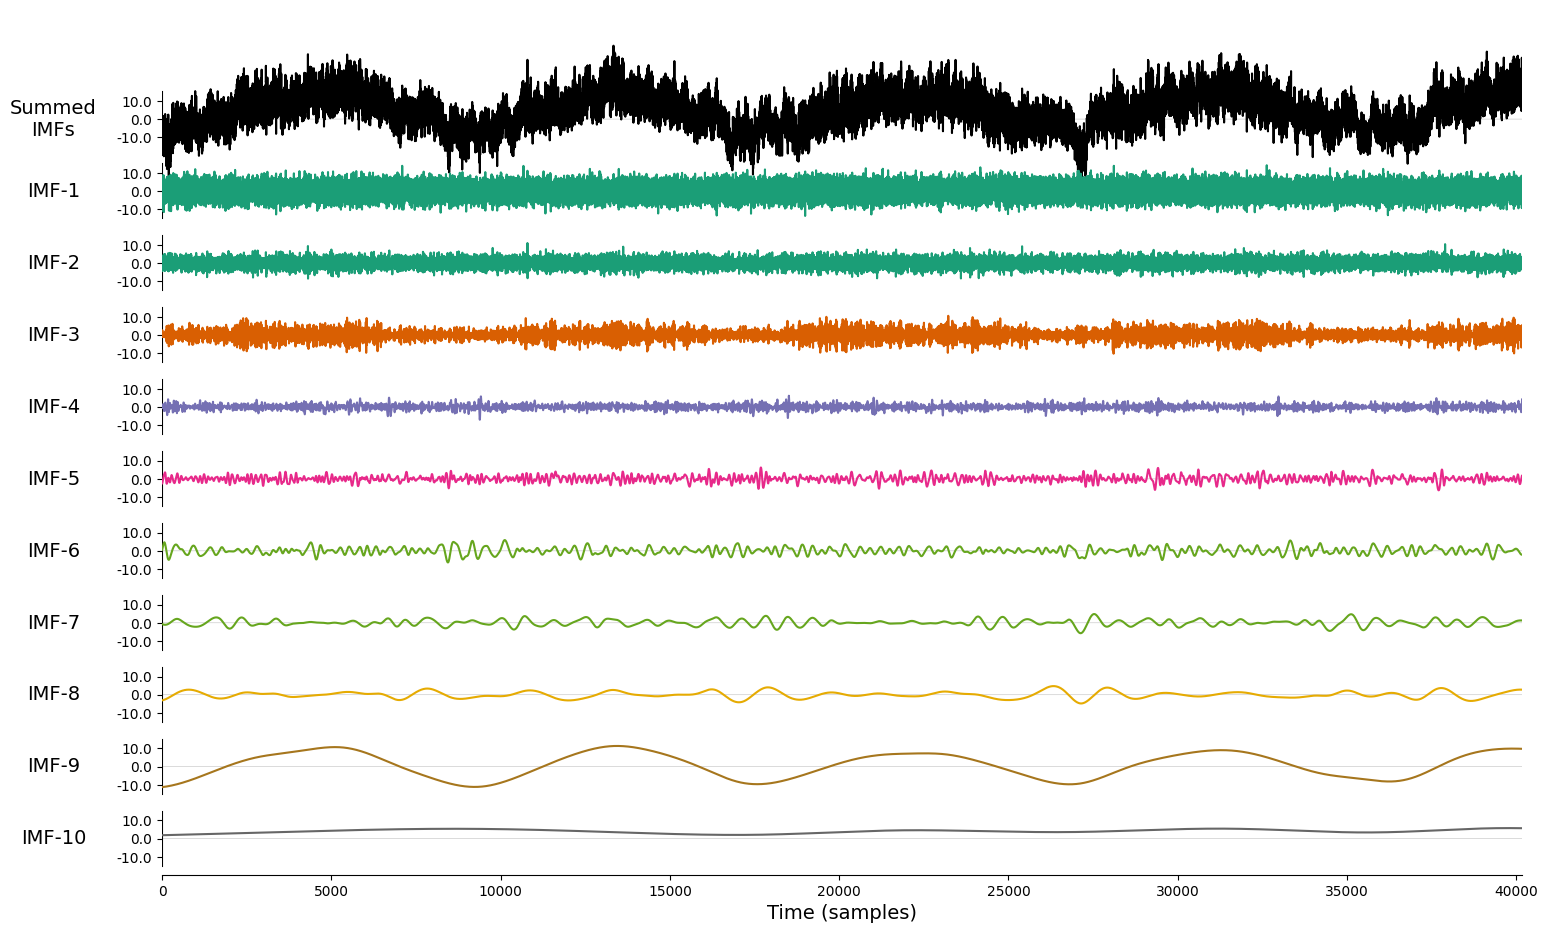

In [3]:
# Descomposición EEMD
imf_eemd = emd.sift.ensemble_sift(np.array(train), nensembles=4, nprocesses=6, ensemble_noise=1, imf_opts={'sd_thresh': 0.1})
emd.plotting.plot_imfs(imf_eemd)
imf_eemd_df = pd.DataFrame(data=imf_eemd)
imf_eemd_df.columns = ['imf_eemd_{}'.format(i + 1) for i in range(0, imf_eemd.shape[1])]
display(imf_eemd_df)

In [4]:
# Normalización y preparación de datos para LSTM
def prepare_data(series):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(series.values.reshape(-1, 1))
    
    X, y = [], []
    for i in range(1, len(scaled_data)):
        X.append(scaled_data[i-1:i, 0])
        y.append(scaled_data[i, 0])
        
    return np.array(X), np.array(y), scaler

In [5]:
# Entrenamiento de modelos LSTM para IMFs 1 al 7
# IMF 1
imf1_eemd_lstm_X, imf1_eemd_lstm_y, scaler1 = prepare_data(imf_eemd_df['imf_eemd_1'])
imf1_eemd_lstm_X = imf1_eemd_lstm_X.reshape((imf1_eemd_lstm_X.shape[0], 1, imf1_eemd_lstm_X.shape[1]))

model1 = Sequential()
model1.add(LSTM(10, activation='relu', input_shape=(imf1_eemd_lstm_X.shape[1], imf1_eemd_lstm_X.shape[2])))
model1.add(Dense(1))
model1.compile(optimizer='adam', loss='mse')
model1.fit(imf1_eemd_lstm_X, imf1_eemd_lstm_y, epochs=200, verbose=0)
imf1_eemd_lstm_fc = model1.predict(imf1_eemd_lstm_X[-len(test):].reshape((len(test), 1, 1)))
imf1_eemd_lstm_fc = scaler1.inverse_transform(imf1_eemd_lstm_fc)

# IMF 2
imf2_eemd_lstm_X, imf2_eemd_lstm_y, scaler2 = prepare_data(imf_eemd_df['imf_eemd_2'])
imf2_eemd_lstm_X = imf2_eemd_lstm_X.reshape((imf2_eemd_lstm_X.shape[0], 1, imf2_eemd_lstm_X.shape[1]))

model2 = Sequential()
model2.add(LSTM(10, activation='relu', input_shape=(imf2_eemd_lstm_X.shape[1], imf2_eemd_lstm_X.shape[2])))
model2.add(Dense(1))
model2.compile(optimizer='adam', loss='mse')
model2.fit(imf2_eemd_lstm_X, imf2_eemd_lstm_y, epochs=200, verbose=0)
imf2_eemd_lstm_fc = model2.predict(imf2_eemd_lstm_X[-len(test):].reshape((len(test), 1, 1)))
imf2_eemd_lstm_fc = scaler2.inverse_transform(imf2_eemd_lstm_fc)

# IMF 3
imf3_eemd_lstm_X, imf3_eemd_lstm_y, scaler3 = prepare_data(imf_eemd_df['imf_eemd_3'])
imf3_eemd_lstm_X = imf3_eemd_lstm_X.reshape((imf3_eemd_lstm_X.shape[0], 1, imf3_eemd_lstm_X.shape[1]))

model3 = Sequential()
model3.add(LSTM(10, activation='relu', input_shape=(imf3_eemd_lstm_X.shape[1], imf3_eemd_lstm_X.shape[2])))
model3.add(Dense(1))
model3.compile(optimizer='adam', loss='mse')
model3.fit(imf3_eemd_lstm_X, imf3_eemd_lstm_y, epochs=200, verbose=0)
imf3_eemd_lstm_fc = model3.predict(imf3_eemd_lstm_X[-len(test):].reshape((len(test), 1, 1)))
imf3_eemd_lstm_fc = scaler3.inverse_transform(imf3_eemd_lstm_fc)

# IMF 4
imf4_eemd_lstm_X, imf4_eemd_lstm_y, scaler4 = prepare_data(imf_eemd_df['imf_eemd_4'])
imf4_eemd_lstm_X = imf4_eemd_lstm_X.reshape((imf4_eemd_lstm_X.shape[0], 1, imf4_eemd_lstm_X.shape[1]))

model4 = Sequential()
model4.add(LSTM(10, activation='relu', input_shape=(imf4_eemd_lstm_X.shape[1], imf4_eemd_lstm_X.shape[2])))
model4.add(Dense(1))
model4.compile(optimizer='adam', loss='mse')
model4.fit(imf4_eemd_lstm_X, imf4_eemd_lstm_y, epochs=200, verbose=0)
imf4_eemd_lstm_fc = model4.predict(imf4_eemd_lstm_X[-len(test):].reshape((len(test), 1, 1)))
imf4_eemd_lstm_fc = scaler4.inverse_transform(imf4_eemd_lstm_fc)

# IMF 5
imf5_eemd_lstm_X, imf5_eemd_lstm_y, scaler5 = prepare_data(imf_eemd_df['imf_eemd_5'])
imf5_eemd_lstm_X = imf5_eemd_lstm_X.reshape((imf5_eemd_lstm_X.shape[0], 1, imf5_eemd_lstm_X.shape[1]))

model5 = Sequential()
model5.add(LSTM(10, activation='relu', input_shape=(imf5_eemd_lstm_X.shape[1], imf5_eemd_lstm_X.shape[2])))
model5.add(Dense(1))
model5.compile(optimizer='adam', loss='mse')
model5.fit(imf5_eemd_lstm_X, imf5_eemd_lstm_y, epochs=200, verbose=0)
imf5_eemd_lstm_fc = model5.predict(imf5_eemd_lstm_X[-len(test):].reshape((len(test), 1, 1)))
imf5_eemd_lstm_fc = scaler5.inverse_transform(imf5_eemd_lstm_fc)

# IMF 6
imf6_eemd_lstm_X, imf6_eemd_lstm_y, scaler6 = prepare_data(imf_eemd_df['imf_eemd_6'])
imf6_eemd_lstm_X = imf6_eemd_lstm_X.reshape((imf6_eemd_lstm_X.shape[0], 1, imf6_eemd_lstm_X.shape[1]))

model6 = Sequential()
model6.add(LSTM(10, activation='relu', input_shape=(imf6_eemd_lstm_X.shape[1], imf6_eemd_lstm_X.shape[2])))
model6.add(Dense(1))
model6.compile(optimizer='adam', loss='mse')
model6.fit(imf6_eemd_lstm_X, imf6_eemd_lstm_y, epochs=200, verbose=0)
imf6_eemd_lstm_fc = model6.predict(imf6_eemd_lstm_X[-len(test):].reshape((len(test), 1, 1)))
imf6_eemd_lstm_fc = scaler6.inverse_transform(imf6_eemd_lstm_fc)

# IMF 7
imf7_eemd_lstm_X, imf7_eemd_lstm_y, scaler7 = prepare_data(imf_eemd_df['imf_eemd_7'])
imf7_eemd_lstm_X = imf7_eemd_lstm_X.reshape((imf7_eemd_lstm_X.shape[0], 1, imf7_eemd_lstm_X.shape[1]))

model7 = Sequential()
model7.add(LSTM(10, activation='relu', input_shape=(imf7_eemd_lstm_X.shape[1], imf7_eemd_lstm_X.shape[2])))
model7.add(Dense(1))
model7.compile(optimizer='adam', loss='mse')
model7.fit(imf7_eemd_lstm_X, imf7_eemd_lstm_y, epochs=200, verbose=0)
imf7_eemd_lstm_fc = model7.predict(imf7_eemd_lstm_X[-len(test):].reshape((len(test), 1, 1)))
imf7_eemd_lstm_fc = scaler7.inverse_transform(imf7_eemd_lstm_fc)

# # IMF 8
# imf8_eemd_lstm_X, imf8_eemd_lstm_y, scaler8 = prepare_data(imf_eemd_df['imf_eemd_8'])
# imf8_eemd_lstm_X = imf8_eemd_lstm_X.reshape((imf8_eemd_lstm_X.shape[0], 1, imf8_eemd_lstm_X.shape[1]))

# model8 = Sequential()
# model8.add(LSTM(10, activation='relu', input_shape=(imf8_eemd_lstm_X.shape[1], imf8_eemd_lstm_X.shape[2])))
# model8.add(Dense(1))
# model8.compile(optimizer='adam', loss='mse')
# model8.fit(imf8_eemd_lstm_X, imf8_eemd_lstm_y, epochs=200, verbose=0)
# imf8_eemd_lstm_fc = model8.predict(imf8_eemd_lstm_X[-len(test):].reshape((len(test), 1, 1)))
# imf8_eemd_lstm_fc = scaler8.inverse_transform(imf8_eemd_lstm_fc)

# # IMF 9
# imf9_eemd_lstm_X, imf9_eemd_lstm_y, scaler9 = prepare_data(imf_eemd_df['imf_eemd_9'])
# imf9_eemd_lstm_X = imf9_eemd_lstm_X.reshape((imf9_eemd_lstm_X.shape[0], 1, imf9_eemd_lstm_X.shape[1]))

# model9 = Sequential()
# model9.add(LSTM(10, activation='relu', input_shape=(imf9_eemd_lstm_X.shape[1], imf9_eemd_lstm_X.shape[2])))
# model9.add(Dense(1))
# model9.compile(optimizer='adam', loss='mse')
# model9.fit(imf9_eemd_lstm_X, imf9_eemd_lstm_y, epochs=200, verbose=0)
# imf9_eemd_lstm_fc = model9.predict(imf9_eemd_lstm_X[-len(test):].reshape((len(test), 1, 1)))
# imf9_eemd_lstm_fc = scaler9.inverse_transform(imf9_eemd_lstm_fc)

# # IMF 10
# imf10_eemd_lstm_X, imf10_eemd_lstm_y, scaler10 = prepare_data(imf_eemd_df['imf_eemd_10'])
# imf10_eemd_lstm_X = imf10_eemd_lstm_X.reshape((imf10_eemd_lstm_X.shape[0], 1, imf10_eemd_lstm_X.shape[1]))

# model10 = Sequential()
# model10.add(LSTM(10, activation='relu', input_shape=(imf10_eemd_lstm_X.shape[1], imf10_eemd_lstm_X.shape[2])))
# model10.add(Dense(1))
# model10.compile(optimizer='adam', loss='mse')
# model10.fit(imf10_eemd_lstm_X, imf10_eemd_lstm_y, epochs=200, verbose=0)
# imf10_eemd_lstm_fc = model10.predict(imf10_eemd_lstm_X[-len(test):].reshape((len(test), 1, 1)))
# imf10_eemd_lstm_fc = scaler10.inverse_transform(imf10_eemd_lstm_fc)

c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [6]:
from statsmodels.tsa.arima.model import ARIMA

imf8_eemd_arima = ARIMA(imf_eemd_df['imf_eemd_8'], order=(2, 1, 5)).fit()
imf8_eemd_arima_fc = imf8_eemd_arima.forecast(steps=len(test))

imf9_eemd_arima = ARIMA(imf_eemd_df['imf_eemd_9'], order=(2, 1, 5)).fit()
imf9_eemd_arima_fc = imf9_eemd_arima.forecast(steps=len(test))

imf10_eemd_arima = ARIMA(imf_eemd_df['imf_eemd_10'], order=(2, 1, 5)).fit()
imf10_eemd_arima_fc = imf10_eemd_arima.forecast(steps=len(test))

c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\stat

In [11]:
imf1_eemd_lstm_fc.shape

(10045, 1)

In [12]:
imf8_eemd_arima_fc.shape

(10045,)

In [14]:
# Asegurar que todas las predicciones de LSTM sean de forma (10045,)
imf1_eemd_lstm_fc_1 = imf1_eemd_lstm_fc.reshape(-1)
imf2_eemd_lstm_fc_2 = imf2_eemd_lstm_fc.reshape(-1)
imf3_eemd_lstm_fc_3 = imf3_eemd_lstm_fc.reshape(-1)
imf4_eemd_lstm_fc_4 = imf4_eemd_lstm_fc.reshape(-1)
imf5_eemd_lstm_fc_5 = imf5_eemd_lstm_fc.reshape(-1)
imf6_eemd_lstm_fc_6 = imf6_eemd_lstm_fc.reshape(-1)
imf7_eemd_lstm_fc_7 = imf7_eemd_lstm_fc.reshape(-1)

# Sumar las predicciones
imf_lstm_fc = np.sum([
    imf1_eemd_lstm_fc_1, imf2_eemd_lstm_fc_2, imf3_eemd_lstm_fc_3,
    imf4_eemd_lstm_fc_4, imf5_eemd_lstm_fc_5, imf6_eemd_lstm_fc_6, imf7_eemd_lstm_fc_7,
    imf8_eemd_arima_fc, imf9_eemd_arima_fc, imf10_eemd_arima_fc
], axis=0)

# Imprime la forma final para verificar
print(imf_lstm_fc.shape)


(10045,)


In [15]:
# # Sumar las predicciones de todos los IMF
# imf_lstm_fc = np.sum([imf1_eemd_lstm_fc, imf2_eemd_lstm_fc, imf3_eemd_lstm_fc, imf4_eemd_lstm_fc, imf5_eemd_lstm_fc,
#                       imf6_eemd_lstm_fc, imf7_eemd_lstm_fc, imf8_eemd_arima_fc, imf9_eemd_arima_fc, imf10_eemd_arima_fc], axis=0)

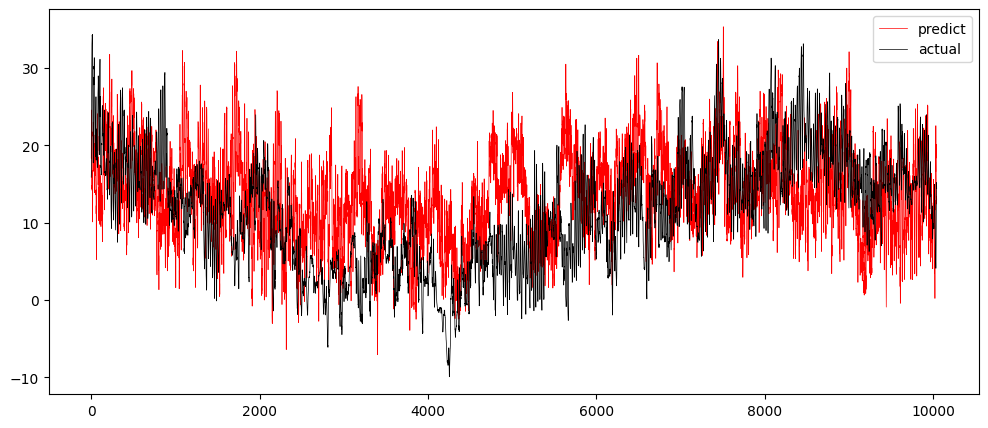

RMSE = 8.725167999152594 
MAE = 7.065571392450249 
MAPE = 11400303455577.873


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [17]:
# Visualizar resultados
plt.figure(figsize=(12, 5))
plt.plot(imf_lstm_fc, label='predict', color='r', linewidth=0.5)
plt.plot(test.values, label='actual', color='k', linewidth=0.5)
plt.legend()
plt.show()

# Calcular métricas de error
RMSE_EEMD_LSTM = mean_squared_error(test, imf_lstm_fc, squared=False)
MAE_EEMD_LSTM = mean_absolute_error(test, imf_lstm_fc)
MAPE_EEMD_LSTM = mean_absolute_percentage_error(test, imf_lstm_fc)

print('RMSE = {}'.format(RMSE_EEMD_LSTM), 
      '\nMAE = {}'.format(MAE_EEMD_LSTM), 
      '\nMAPE = {}'.format(MAPE_EEMD_LSTM))

In [ ]:
# Visualizar resultados
plt.plot(imf_lstm_fc, label='predict', color='r', linewidth=0.5)
plt.plot(test.values, label='actual', color='k', linewidth=0.5)
plt.legend()
plt.savefig('EEMDLSTM')
plt.show()